In [1]:
%matplotlib inline
import matplotlib as mpl
import matplotlib.pyplot as plt
from matplotlib.animation import FuncAnimation
from IPython.display import HTML
plt.rcParams.update({
    'figure.figsize': (3.6, 2.7), 'font.size': 15, 'lines.linewidth': 2,
    'xtick.labelsize': 'small', 'ytick.labelsize': 'small',
    'legend.fontsize': 'small', 'axes.titlesize': 'medium',
    'axes.spines.top': False, 'axes.spines.right': False,
    'image.interpolation': 'nearest', 'savefig.dpi': 100,
})

import os
import torch
import pickle
from pathlib import Path
import numpy as np
from jarvis.utils import tqdm

from hexarena import STORE_DIR
FIG_DIR = Path('figures')
os.makedirs(FIG_DIR, exist_ok=True)
rng = np.random.default_rng()

# Create single box foraging environment

A policy with fixed push probability is used to generate an episode.

In [2]:
from hexarena.env import BanditForagingEnv

tau = 7.5
env = BanditForagingEnv(boxes=[{'_target_': 'hexarena.box.PoissonBox', 'tau': tau, 'tau_in_state': True, 'cue_in_state': False}])

In [3]:
_, info = env.reset()
env_states = []
obss = []
actions = []

n_steps = 600
for _ in range(n_steps):
    action = int(rng.random()>0.2)
    actions.append(action)
    *_, info = env.step(action)
    env_states.append(info['env_state'])
    obss.append(info['obs'])

# Create an initial distribution of $\tau$

In [4]:
from gymnasium.spaces import Box
from irc.dist.space import Space
from irc.dist.distribution import create_distribution

space = Space(Box(low=0, high=np.inf))
dist = create_distribution(space.spaces)
n_samples = 1000
taus = rng.choice([7.5, 10.5, 17.5], size=(n_samples, 1))
space.update_spaces(taus)

param_vecs, _ = dist.estimate(torch.stack([space.encode(tau) for tau in taus]), sga_kw={'pbar_kw': {'disable': True}}, dfp_kw={'pbar_kw': {'disable': True}})
param_vec = param_vecs[0]

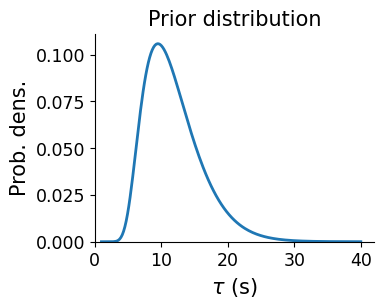

In [5]:
taus = np.linspace(1, 40, 200)
logps, _ = dist.loglikelihoods(
    torch.stack([space.encode(tau) for tau in taus]), param_vec, original=True,
)
ps = logps.exp()

_, ax = plt.subplots()
ax.plot(taus, ps)
ax.set_xlabel(r'$\tau$ (s)')
ax.set_ylabel('Prob. dens.')
ax.set_xlim([0, None])
ax.set_ylim([0, None])
ax.set_title('Prior distribution')
plt.show()

# Theoretical Bayesian updates of belief on $\tau$

In [64]:
ps = [torch.softmax(logps, dim=0)]
logL = torch.zeros_like(logps)
for action, obs in zip(actions, obss):
    if action==1: # no-push
        logL -= 1/torch.tensor(taus, dtype=torch.float)
    else:
        if obs['rewarded']==0:
            logps += logL
        else:
            logps += torch.log(1-torch.exp(logL))
        logL = torch.zeros_like(logps)
    ps.append(torch.softmax(logps, dim=0))
ps = torch.stack(ps)/(taus[1]-taus[0])

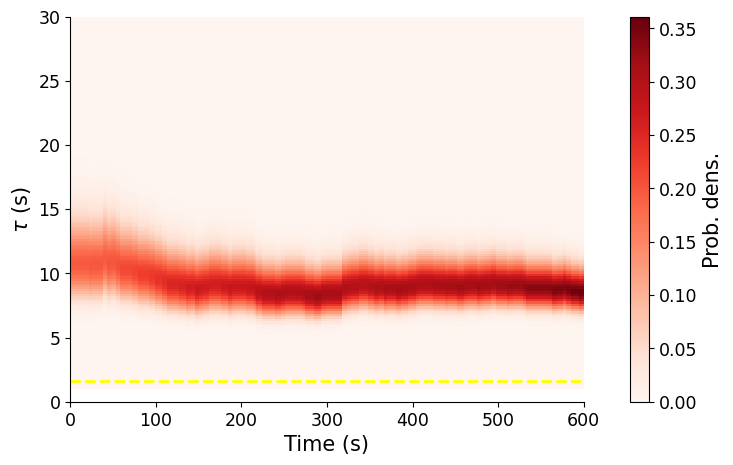

In [65]:
fig, ax = plt.subplots(figsize=(12, 5))
h = ax.imshow(ps.T, extent=[0, n_steps, taus.max(), taus.min()], aspect=n_steps/40, vmin=0, cmap='Reds')
fig.colorbar(h, label='Prob. dens.')
ax.plot([0, n_steps], np.ones(2)*tau, color='yellow', linewidth=2, linestyle='--')
ax.set_ylim([0, 30])
ax.set_xlabel('Time (s)')
ax.set_ylabel(r'$\tau$ (s)')
plt.show()

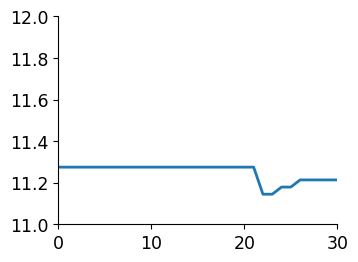

In [69]:
_, ax = plt.subplots()
ax.plot((ps.numpy()*taus*(taus[1]-taus[0])).sum(axis=1))
ax.set_xlim([0, 30])
ax.set_ylim([11, 12])
plt.show()

In [76]:
actions[23]

0

In [77]:
obss[23]

{'rewarded': 0}

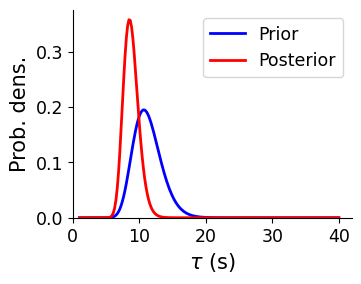

In [66]:
_, ax = plt.subplots()
ax.plot(taus, ps[0], color='blue')
ax.plot(taus, ps[-1], color='red')
ax.legend(['Prior', 'Posterior'])
ax.set_xlabel(r'$\tau$ (s)')
ax.set_ylabel('Prob. dens.')
ax.set_xlim([0, None])
ax.set_ylim([0, None])
plt.show()

# Create belief model

In [55]:
from irc.model import SamplingBeliefModel

cliques = {
    'env': [
        [('box_0', 'food'), ('box_0', 'tau', (0,))],
    ],
}

model = SamplingBeliefModel(env, cliques=cliques, n_samples=n_samples)
model.use_sample = True

l2_reg = 0.001
model.estimate_kw.update({'l2_reg': l2_reg})

In [56]:
from jarvis.utils import tensor2array, array2tensor

ckpt_pth = STORE_DIR/'single.box.pkl'
if os.path.exists(ckpt_pth):
    with open(ckpt_pth, 'rb') as f:
        ckpt = array2tensor(pickle.load(f))
    model.load_state_dict(ckpt['model'])
    beliefs = ckpt['beliefs']
    infos = ckpt['infos']
else:
    env_states = []
    for _ in range(model.n_samples):
        env_states.append({'box_0': {'tau': rng.choice([7.5, 10.5, 17.5], size=(1,)), 'food': 0}})
    model.env_space.update_spaces(env_states)
    param_vecs, stats = model.p_s.estimate(
        torch.stack([model.env_space.encode(s) for s in env_states]),
        sga_kw={'pbar_kw': {'disable': True}}, dfp_kw={'pbar_kw': {'disable': True}},
        l2_reg=l2_reg,
    )
    belief = param_vecs[0]
    info = {'states': env_states, 'estimate_stats': stats}
    with open(ckpt_pth, 'wb') as f:
        pickle.dump(tensor2array({
            'beliefs': [belief], 'infos': [info],
        }), f)
    
    beliefs, infos = model.compute_beliefs(
        [{} for _ in range(n_steps+1)],
        [{'rewarded': 0}]+obss, actions,
        ckpt_pth=ckpt_pth,
    )
    
    with open(ckpt_pth, 'wb') as f:
        pickle.dump(tensor2array({
            'beliefs': beliefs, 'infos': infos,
            'model': model.state_dict(),
        }), f)

Compute beliefs:   0%|#1                                                                                      …

In [78]:
def get_p_tau(p_s, belief, taus):
    ps = []
    for food in range(2):
        logps, _ = p_s.loglikelihoods(
            torch.stack([model.env_space.encode({
                'box_0': {'tau': np.array([tau]), 'food': food},
            }) for tau in taus]), belief, original=True,
        )
        ps.append(logps.exp())
    ps = torch.stack(ps)
    return ps

p_s = model.p_s
ps = torch.stack([get_p_tau(p_s, belief, taus) for belief in beliefs])

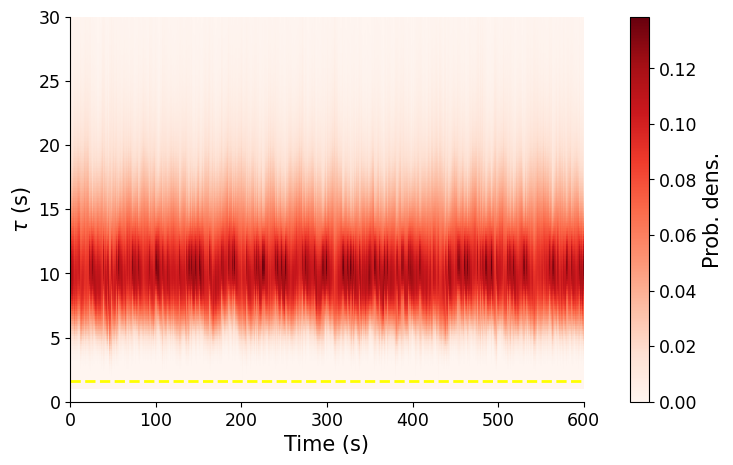

In [79]:
fig, ax = plt.subplots(figsize=(12, 5))
h = ax.imshow(ps.sum(dim=1).T, extent=[0, n_steps, taus.max(), taus.min()], aspect=n_steps/40, vmin=0, cmap='Reds')
fig.colorbar(h, label='Prob. dens.')
ax.plot([0, n_steps], np.ones(2)*tau, color='yellow', linewidth=2, linestyle='--')
ax.set_ylim([0, 30])
ax.set_xlabel('Time (s)')
ax.set_ylabel(r'$\tau$ (s)')
plt.show()

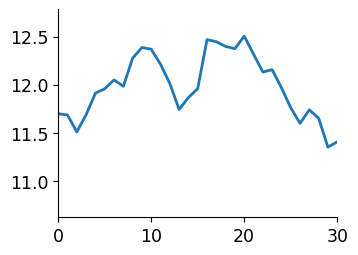

In [80]:
_, ax = plt.subplots()
ax.plot((ps.sum(dim=1).numpy()*taus*(taus[1]-taus[0])).sum(axis=1))
ax.set_xlim([0, 30])
plt.show()

In [44]:
def get_p_tau(p_s, belief, taus):
    ps = []
    for food in range(2):
        logps, _ = p_s.loglikelihoods(
            torch.stack([model.env_space.encode({
                'box_0': {'tau': np.array([tau]), 'food': food},
            }) for tau in taus]), belief, original=True,
        )
        ps.append(logps.exp())
    ps = torch.stack(ps)
    return ps

p_s = model.p_s
ps = torch.stack([get_p_tau(p_s, belief, taus) for belief in beliefs])

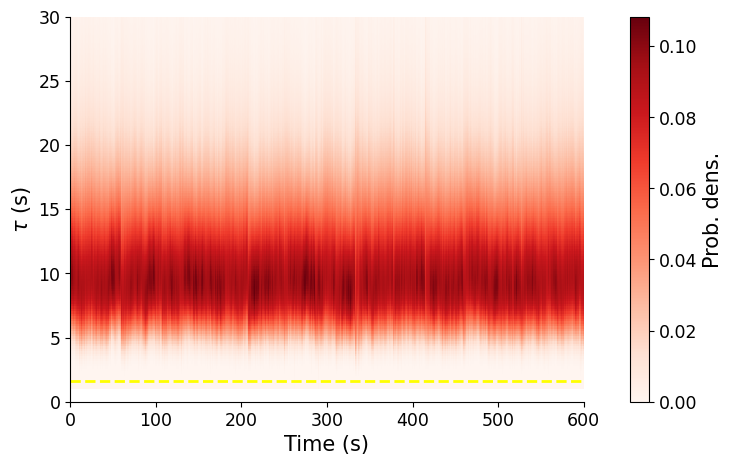

In [45]:
fig, ax = plt.subplots(figsize=(12, 5))
h = ax.imshow(ps.sum(dim=1).T, extent=[0, n_steps, taus.max(), taus.min()], aspect=n_steps/40, vmin=0, cmap='Reds')
fig.colorbar(h, label='Prob. dens.')
ax.plot([0, n_steps], np.ones(2)*tau, color='yellow', linewidth=2, linestyle='--')
ax.set_ylim([0, 30])
ax.set_xlabel('Time (s)')
ax.set_ylabel(r'$\tau$ (s)')
plt.show()